In [42]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import ast
import unicodedata
import numpy as np
import re
from matplotlib import colors as mcolors


CSV_PATH = "Script_generador_tickets_sinteticos_gasolina/data/tickets/tickets_sinteticos.csv"
df = pd.read_csv(CSV_PATH)

In [43]:
df["fechaEmision"] = pd.to_datetime(df["fechaEmision"], errors="coerce")
df["dt"] = pd.to_datetime(df["fechaEmision"].astype(str) + " " + df["horaEmision"], errors="coerce")
df["mes"] = df["dt"].dt.to_period("M").astype(str)
df["hora"] = df["dt"].dt.hour
dias_map = {"Monday":"Lunes","Tuesday":"Martes","Wednesday":"Miércoles","Thursday":"Jueves","Friday":"Viernes","Saturday":"Sábado","Sunday":"Domingo"}
df["dia_semana"] = df["dt"].dt.day_name().map(dias_map)

In [44]:
def _parse(x):
    return ast.literal_eval(x) if isinstance(x,str) else x

df["estacion_parsed"] = df["estacion"].apply(_parse)

def _station_fields(d):
    if isinstance(d,dict):
        return pd.Series({
            "estacion_id": d.get("id"),
            "estacion_nombre": d.get("nombre"),
            "estacion_provincia": d.get("provincia"),
            "estacion_municipio": d.get("municipio") or d.get("localidad"),
            "estacion_lat": d.get("lat") or d.get("latitude") or d.get("latitud"),
            "estacion_lon": d.get("lon") or d.get("lng") or d.get("longitud")
        })
    return pd.Series({"estacion_id":None,"estacion_nombre":None,"estacion_provincia":None,"estacion_municipio":None,"estacion_lat":None,"estacion_lon":None})

df_est = df["estacion_parsed"].apply(_station_fields)
df = pd.concat([df.drop(columns=["estacion_parsed"]), df_est], axis=1)

for c in ["estacion_id","estacion_nombre","estacion_provincia","estacion_municipio"]:
    df[c] = df[c].astype(str).str.strip().replace({"None":pd.NA,"nan":pd.NA})

df["estacion_lat"] = pd.to_numeric(df["estacion_lat"], errors="coerce")
df["estacion_lon"] = pd.to_numeric(df["estacion_lon"], errors="coerce")

def _norm(s):
    if pd.isna(s): return s
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
    return s.upper()

df["estacion_provincia_norm"] = df["estacion_provincia"].apply(_norm)
df["estacion_municipio_norm"] = df["estacion_municipio"].apply(_norm)


In [45]:
def _fix_jsonish(s):
    s = re.sub(r"(?<!\\)'", '"', str(s))
    s = s.replace("None","null").replace("True","true").replace("False","false")
    return s

def parse_lineas(x):
    if isinstance(x, list): return x
    if isinstance(x, dict): return [x]
    if pd.isna(x): return []
    s = _fix_jsonish(x)
    for fn in (json.loads, lambda t: ast.literal_eval(t)):
        try:
            return fn(s)
        except Exception:
            continue
    return []

df["lineas_parsed"] = df["lineas"].apply(parse_lineas)

rows = []
for _, r in df.iterrows():
    for li in (r["lineas_parsed"] if isinstance(r["lineas_parsed"], list) else []):
        litros = li.get("litros")
        ppu = li.get("precioPorLitro") or li.get("precio_unitario") or li.get("precio") or None
        importe_li = li.get("importe") or None
        try: l = float(litros) if litros is not None else np.nan
        except: l = np.nan
        try: p = float(ppu) if ppu is not None else np.nan
        except: p = np.nan
        if pd.isna(p) and importe_li is not None and pd.notna(l) and l>0:
            try: p = float(importe_li)/l
            except: pass
        importe = (l*p) if (pd.notna(l) and pd.notna(p)) else np.nan
        rows.append({
            "idTicket": r["idTicket"],
            "empresaTransporte": r.get("empresaNombre", pd.NA),
            "idUsuario": r["idUsuario"],
            "dt": r["dt"], "mes": r["mes"], "hora": r["hora"], "dia_semana": r["dia_semana"],
            "producto": li.get("producto"),
            "litros": l, "precio_litro": p, "importe_linea": importe,
            "baseImponible": r["baseImponible"], "iva": r["iva"], "total": r["total"], "metodoPago": r["metodoPago"],
            "estacion_id": r.get("estacion_id"), "estacion_nombre": r.get("estacion_nombre"),
            "estacion_provincia": r.get("estacion_provincia"), "estacion_provincia_norm": r.get("estacion_provincia_norm"),
            "estacion_municipio": r.get("estacion_municipio"), "estacion_municipio_norm": r.get("estacion_municipio_norm"),
            "estacion_lat": r.get("estacion_lat"), "estacion_lon": r.get("estacion_lon")
        })
df_lines = pd.DataFrame(rows)
for c in ["litros","precio_litro","importe_linea","baseImponible","iva","total","estacion_lat","estacion_lon"]:
    df_lines[c] = pd.to_numeric(df_lines[c], errors="coerce")


In [ ]:
    ticket_litros = df_lines.groupby("idTicket")["litros"].sum().rename("litros_ticket")
    ticket_totales = df.groupby("idTicket")[["baseImponible","total"]].sum()
    tk = pd.concat([ticket_litros, ticket_totales], axis=1).reset_index()
    tk["eur_l_total_ticket"] = np.where(tk["litros_ticket"]>0, tk["total"]/tk["litros_ticket"], np.nan)
    tk["eur_l_neto_ticket"]  = np.where(tk["litros_ticket"]>0, tk["baseImponible"]/tk["litros_ticket"], np.nan)

    df_lines = df_lines.merge(tk[["idTicket","eur_l_total_ticket","eur_l_neto_ticket"]], on="idTicket", how="left")
    df_lines["precio_litro"] = df_lines["precio_litro"].fillna(df_lines["eur_l_total_ticket"]).fillna(df_lines["eur_l_neto_ticket"])
    df_lines["importe_linea"] = np.where(
        df_lines["importe_linea"].isna() & df_lines["litros"].notna() & df_lines["precio_litro"].notna(),
        df_lines["litros"]*df_lines["precio_litro"],
        df_lines["importe_linea"]
    )

In [47]:
def _norm_txt(s):
    if pd.isna(s): return s
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"[^A-Z0-9 ]"," ", s.upper())
    s = re.sub(r"\s+"," ", s).strip()
    return s

BRANDS = ["REPSOL","CEPSA","BP","GALP","SHELL","PETRONOR","AVIA","BALLENOIL","CARREFOUR","ALCAMPO","EROSKI","PLENOIL","PETROPRIX","VALCARCE","MEROIL","Q8","ALDRO","CAMPSA","TAMOIL","GM OIL","NATURGY","DISA","SARRION","AUTONET OIL","BONAREA","AGRO","ECOIL","E.LECLERC","LOW COST","EVOIL","PETROL","ENERGY","RAPIFOIL","EASYGAS","COTRONIC","BP EXPRESS","GALP EXPRESS"]

def _match_brand(name):
    n = _norm_txt(name)
    if not n: return pd.NA
    for b in BRANDS:
        if b in n: return b
    return "OTRAS"

df["estacion_nombre_norm"] = df["estacion_nombre"].apply(_norm_txt)
df["estacion_marca"] = df["estacion_nombre"].apply(_match_brand)
df_lines = df_lines.drop(columns=[c for c in ["estacion_marca"] if c in df_lines.columns]).merge(df[["idTicket","estacion_marca"]], on="idTicket", how="left")



In [48]:
EMPRESAS = sorted(df_lines["empresaTransporte"].dropna().unique().tolist())
PALETTE = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
EMP_COLOR = {e: PALETTE[i % len(PALETTE)] for i,e in enumerate(EMPRESAS)}
MESES = sorted(df["mes"].unique().tolist())
orden_sem = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]


In [49]:
gasto_mes_emp   = df.groupby(["empresaNombre","mes"])["total"].sum().reset_index().rename(columns={"empresaNombre":"empresa"})
gasto_total_emp = df.groupby("empresaNombre")["total"].sum().reset_index().rename(columns={"empresaNombre":"empresa","total":"gasto_total_periodo"})
vehiculos_emp   = df.groupby("empresaNombre")["idUsuario"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idUsuario":"num_vehiculos"})
gasto_medio_veh = df.groupby(["empresaNombre","idUsuario"])["total"].sum().groupby("empresaNombre").mean().reset_index().rename(columns={"empresaNombre":"empresa","total":"gasto_medio_por_vehiculo"})
ranking_veh     = df.groupby(["empresaNombre","idUsuario"])["total"].sum().reset_index().rename(columns={"empresaNombre":"empresa","total":"gasto_usuario"})

litros_mes_emp  = df_lines.groupby(["empresaTransporte","mes"])["litros"].sum().reset_index().rename(columns={"empresaTransporte":"empresa"})
litros_veh_emp  = df_lines.groupby(["empresaTransporte","idUsuario"])["litros"].sum().reset_index().rename(columns={"empresaTransporte":"empresa"})

precio_global_emp = (df_lines.assign(w=df_lines["litros"])
                     .groupby("empresaTransporte")
                     .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())
                     .reset_index(name="eur_l")
                     .rename(columns={"empresaTransporte":"empresa"}))

precio_marca_emp = (df_lines.assign(w=df_lines["litros"])
                    .groupby(["empresaTransporte","estacion_marca"])
                    .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())
                    .reset_index(name="eur_l")
                    .rename(columns={"empresaTransporte":"empresa"}))

tickets_dia_emp = df.groupby(["empresaNombre","dia_semana"])["idTicket"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idTicket":"tickets"})
tickets_dia_emp["dia_semana"] = pd.Categorical(tickets_dia_emp["dia_semana"], categories=orden_sem, ordered=True)
tickets_hora_emp = df.groupby(["empresaNombre","hora"])["idTicket"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idTicket":"tickets"})

fin_semana_emp = (
    df.assign(is_weekend=df["dia_semana"].isin(["Sábado","Domingo"]))
      .groupby("empresaNombre")["is_weekend"]
      .mean()
      .mul(100)
      .reset_index()
      .rename(columns={"empresaNombre":"empresa", "is_weekend":"pct_fin_de_semana"})
)

met_global_emp = df.groupby(["empresaNombre","metodoPago"])["idTicket"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idTicket":"tickets"})
met_global_pct = (met_global_emp.assign(total=lambda x: x.groupby("empresa")["tickets"].transform("sum"))
                  .assign(pct=lambda x: 100*x["tickets"]/x["total"])
                  .drop(columns=["total"]))
met_mes_emp = df.groupby(["empresaNombre","mes","metodoPago"])["idTicket"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idTicket":"tickets"})
met_mes_emp["pct"] = 100 * met_mes_emp["tickets"] / met_mes_emp.groupby(["empresa","mes"])["tickets"].transform("sum")

POLICY_MAX_EUR_TICKET = 120.0
fuera_politica_emp = df[df["total"] > POLICY_MAX_EUR_TICKET].groupby("empresaNombre")["idTicket"].nunique().reset_index().rename(columns={"empresaNombre":"empresa","idTicket":"tickets_fuera_politica"})

MAX_LITROS_TICKET = 120.0
litros_incoh_emp = (df_lines.groupby("idTicket")["litros"].sum().reset_index()
                    .merge(df[["idTicket","empresaNombre"]], on="idTicket", how="left")
                    .query("litros > @MAX_LITROS_TICKET")
                    .groupby("empresaNombre")["idTicket"].nunique().reset_index()
                    .rename(columns={"empresaNombre":"empresa","idTicket":"tickets_litros_incoherentes"}))


C:\Users\Jon\AppData\Local\Temp\ipykernel_13328\384835060.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())
C:\Users\Jon\AppData\Local\Temp\ipykernel_13328\384835060.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())


In [50]:
resumen_emp = (gasto_total_emp
               .merge(vehiculos_emp, on="empresa", how="left")
               .merge(gasto_medio_veh, on="empresa", how="left")
               .merge(precio_global_emp, on="empresa", how="left")
               .merge(fin_semana_emp, on="empresa", how="left")
               .merge(met_global_pct.pivot(index="empresa", columns="metodoPago", values="pct").fillna(0).add_prefix("pct_"), on="empresa", how="left")
               .merge(fuera_politica_emp, on="empresa", how="left")
               .merge(litros_incoh_emp, on="empresa", how="left"))
resumen_emp = resumen_emp.fillna(0).sort_values("gasto_total_periodo", ascending=False)
resumen_emp


,empresa,gasto_total_periodo,num_vehiculos,gasto_medio_por_vehiculo,eur_l,pct_fin_de_semana,pct_Efectivo,pct_Tarjeta de empresa,tickets_fuera_politica,tickets_litros_incoherentes
0,Transporte_01 S.L.,29301.08,9,3255.675556,1.524903,29.555556,17.333333,82.666667,5.0,0.0
2,Transporte_03 S.L.,29215.19,9,3246.132222,1.554219,30.444444,15.777778,84.222222,1.0,0.0
1,Transporte_02 S.L.,27653.08,9,3072.564444,1.476395,26.222222,15.555556,84.444444,0.0,0.0


In [51]:
emp_users = (df[["empresaNombre","idUsuario"]].drop_duplicates()
             .rename(columns={"empresaNombre":"empresa"}))

gasto_emp_user_mes = (df.groupby(["empresaNombre","idUsuario","mes"])["total"]
                        .sum().reset_index()
                        .rename(columns={"empresaNombre":"empresa"}))

litros_emp_user_mes = (df_lines.groupby(["empresaTransporte","idUsuario","mes"])["litros"]
                        .sum().reset_index()
                        .rename(columns={"empresaTransporte":"empresa"}))

precio_emp_user = (df_lines.assign(w=df_lines["litros"])
                   .groupby(["empresaTransporte","idUsuario"])
                   .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())
                   .reset_index(name="eur_l")
                   .rename(columns={"empresaTransporte":"empresa"}))

metodos_emp_user = (df.groupby(["empresaNombre","idUsuario","metodoPago"])["idTicket"]
                      .nunique().reset_index()
                      .rename(columns={"empresaNombre":"empresa","idTicket":"tickets"}))

metodos_emp_user_mes = (df.groupby(["empresaNombre","idUsuario","mes","metodoPago"])["idTicket"]
                          .nunique().reset_index()
                          .rename(columns={"empresaNombre":"empresa","idTicket":"tickets"}))
metodos_emp_user_mes["pct"] = (100 * metodos_emp_user_mes["tickets"] /
                               metodos_emp_user_mes.groupby(["empresa","idUsuario","mes"])["tickets"].transform("sum"))

tickets_dia_emp_user = (df.groupby(["empresaNombre","idUsuario","dia_semana"])["idTicket"]
                          .nunique().reset_index()
                          .rename(columns={"empresaNombre":"empresa","idTicket":"tickets"}))
tickets_dia_emp_user["dia_semana"] = pd.Categorical(tickets_dia_emp_user["dia_semana"], categories=orden_sem, ordered=True)

tickets_hora_emp_user = (df.groupby(["empresaNombre","idUsuario","hora"])["idTicket"]
                           .nunique().reset_index()
                           .rename(columns={"empresaNombre":"empresa","idTicket":"tickets"}))


C:\Users\Jon\AppData\Local\Temp\ipykernel_13328\3509375942.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["precio_litro"].mul(x["w"]).sum())/x["w"].sum())


In [52]:
PALETTE = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]

def user_colors_for_company(empresa):
    users = emp_users.loc[emp_users["empresa"]==empresa, "idUsuario"].sort_values().tolist()
    cmap = {u: PALETTE[i % len(PALETTE)] for i,u in enumerate(users)}
    return users, cmap


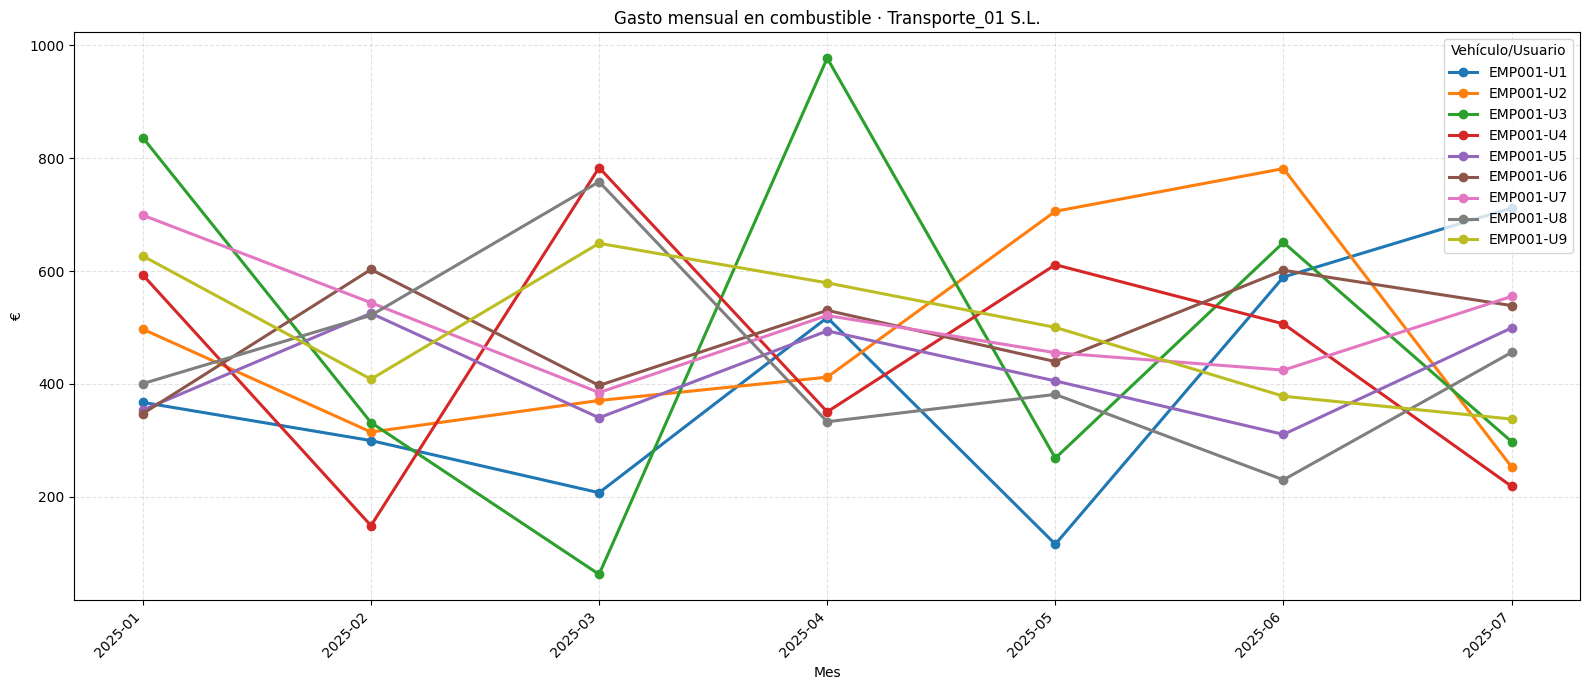

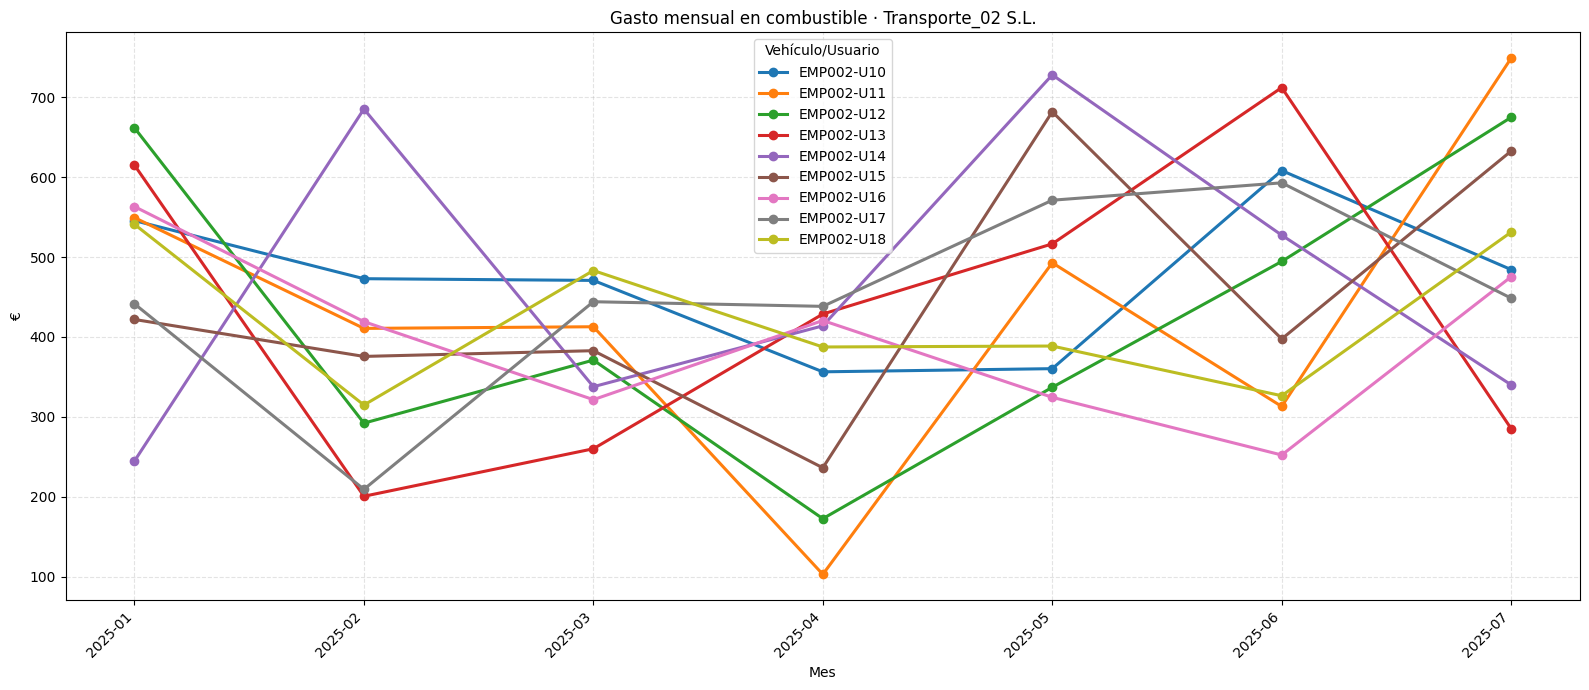

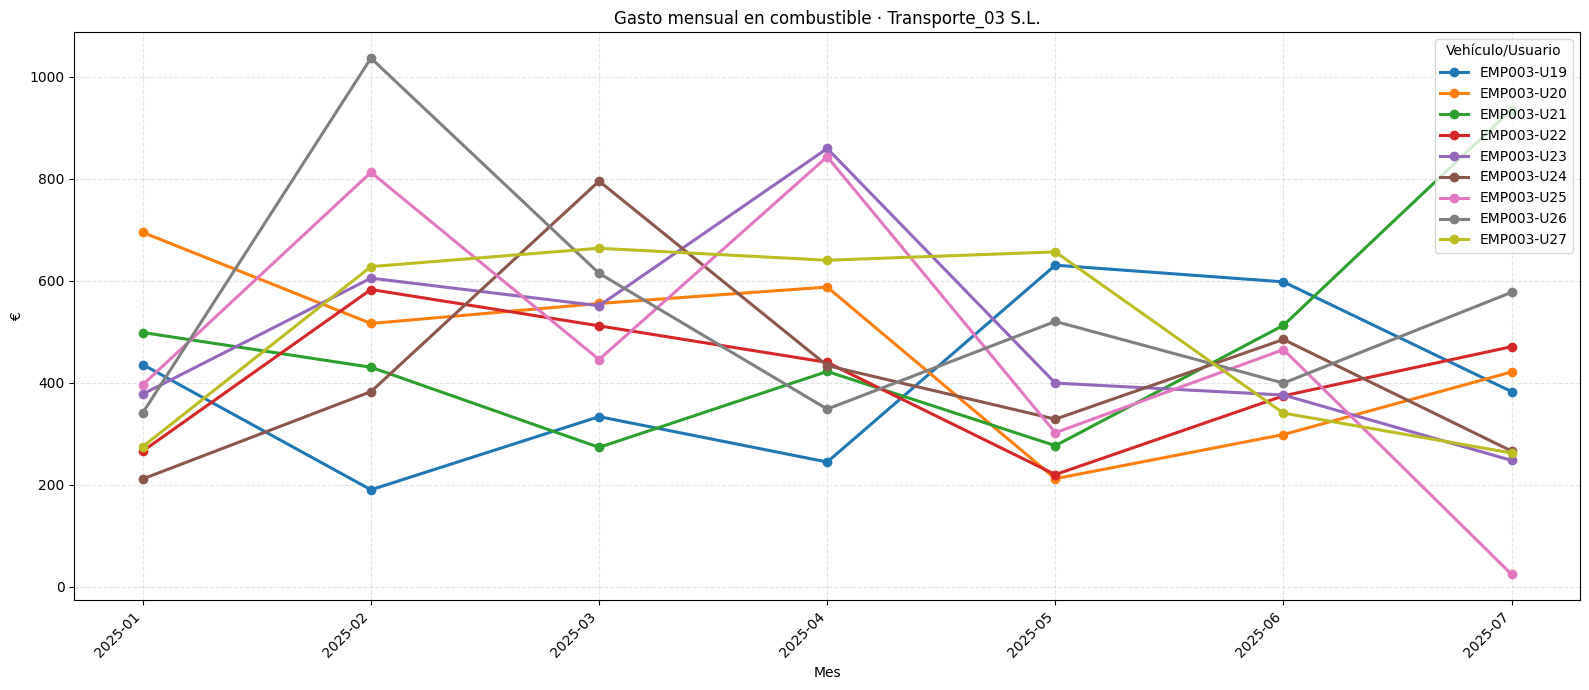

In [53]:
MESES_ALL = sorted(df["mes"].unique().tolist())

for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    plt.figure(figsize=(16,7))
    for u in users:
        tmp = (gasto_emp_user_mes[(gasto_emp_user_mes["empresa"]==e) & (gasto_emp_user_mes["idUsuario"]==u)]
               .set_index("mes").reindex(MESES_ALL).fillna(0))
        plt.plot(MESES_ALL, tmp["total"].values, marker="o", linewidth=2.2, label=str(u), color=cmap[u])
    plt.title(f"Gasto mensual en combustible · {e}")
    plt.xlabel("Mes"); plt.ylabel("€")
    plt.xticks(rotation=45, ha="right"); plt.grid(True, linestyle="--", alpha=0.35); plt.legend(title="Vehículo/Usuario")
    plt.tight_layout(); plt.show()


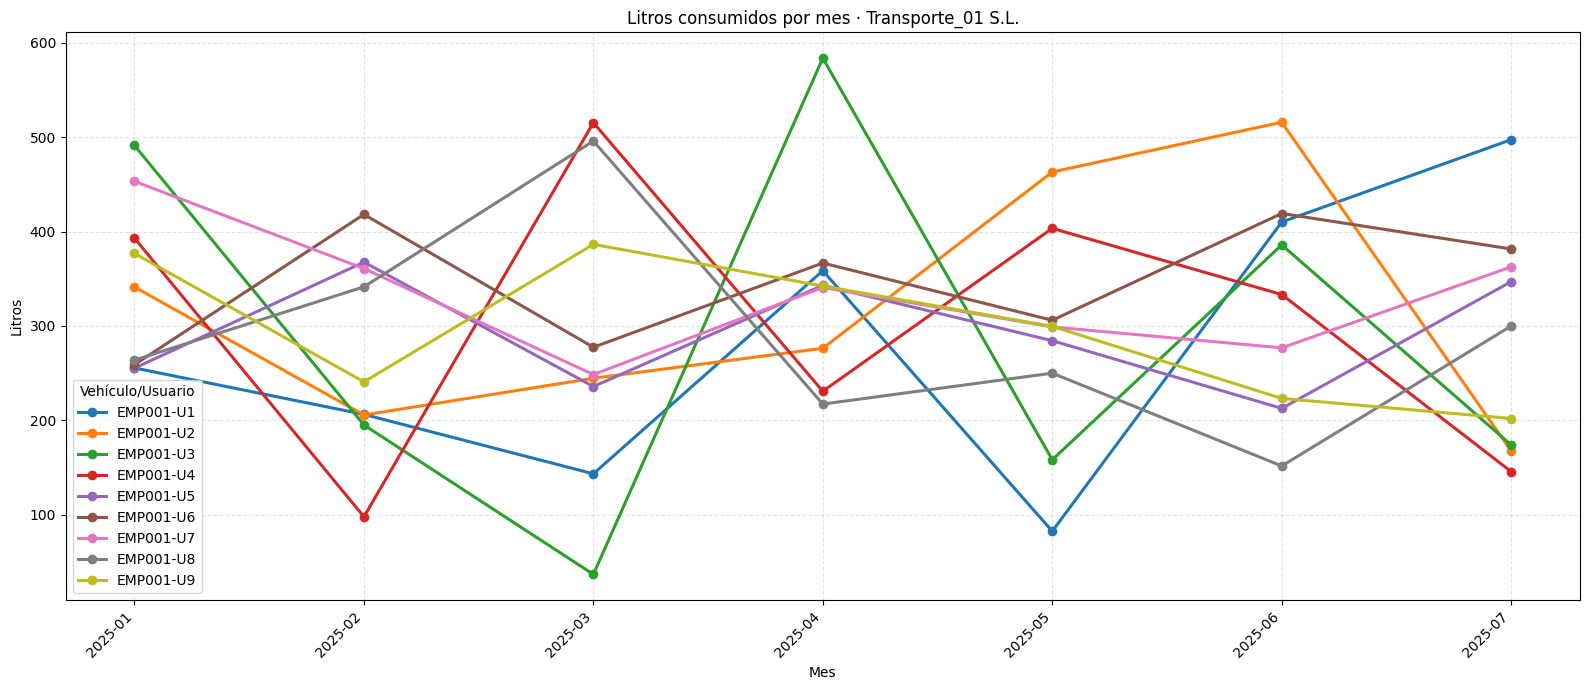

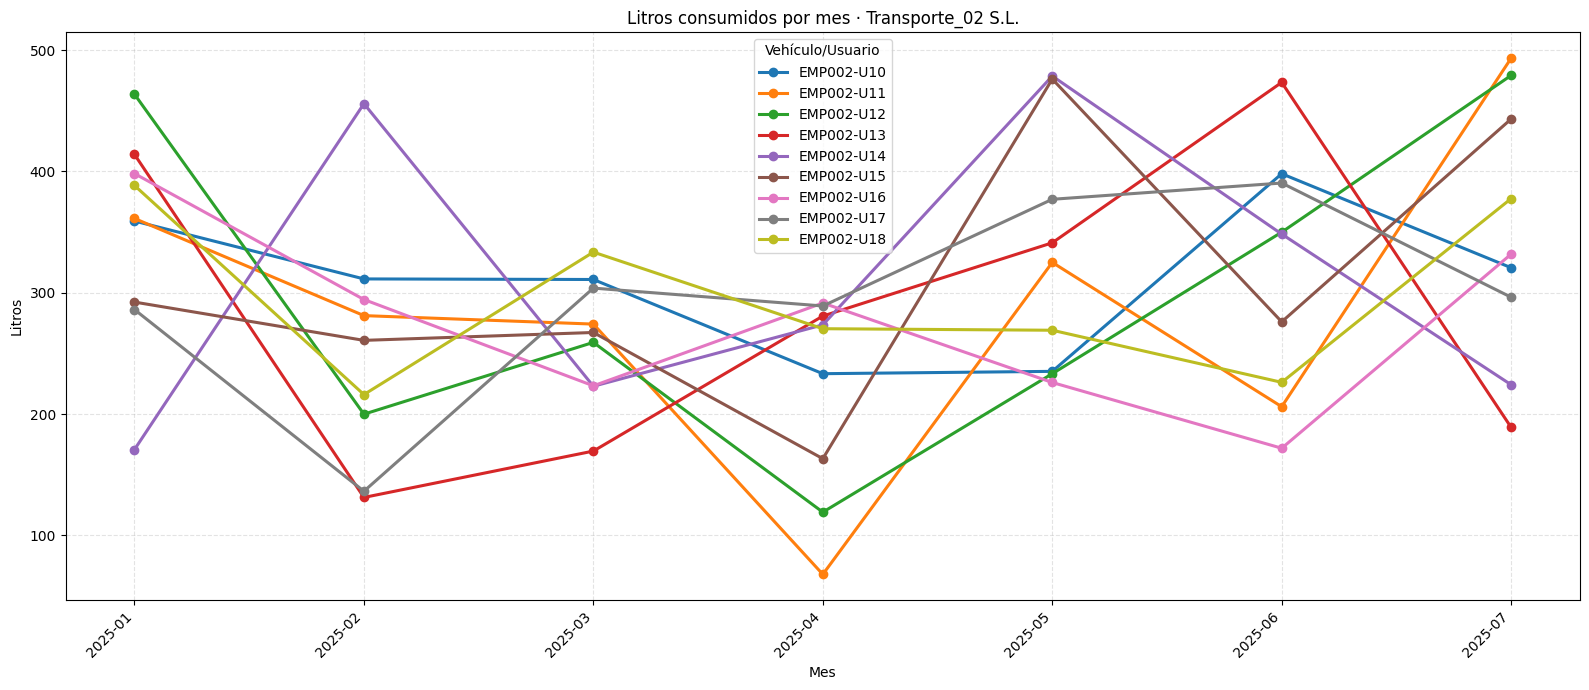

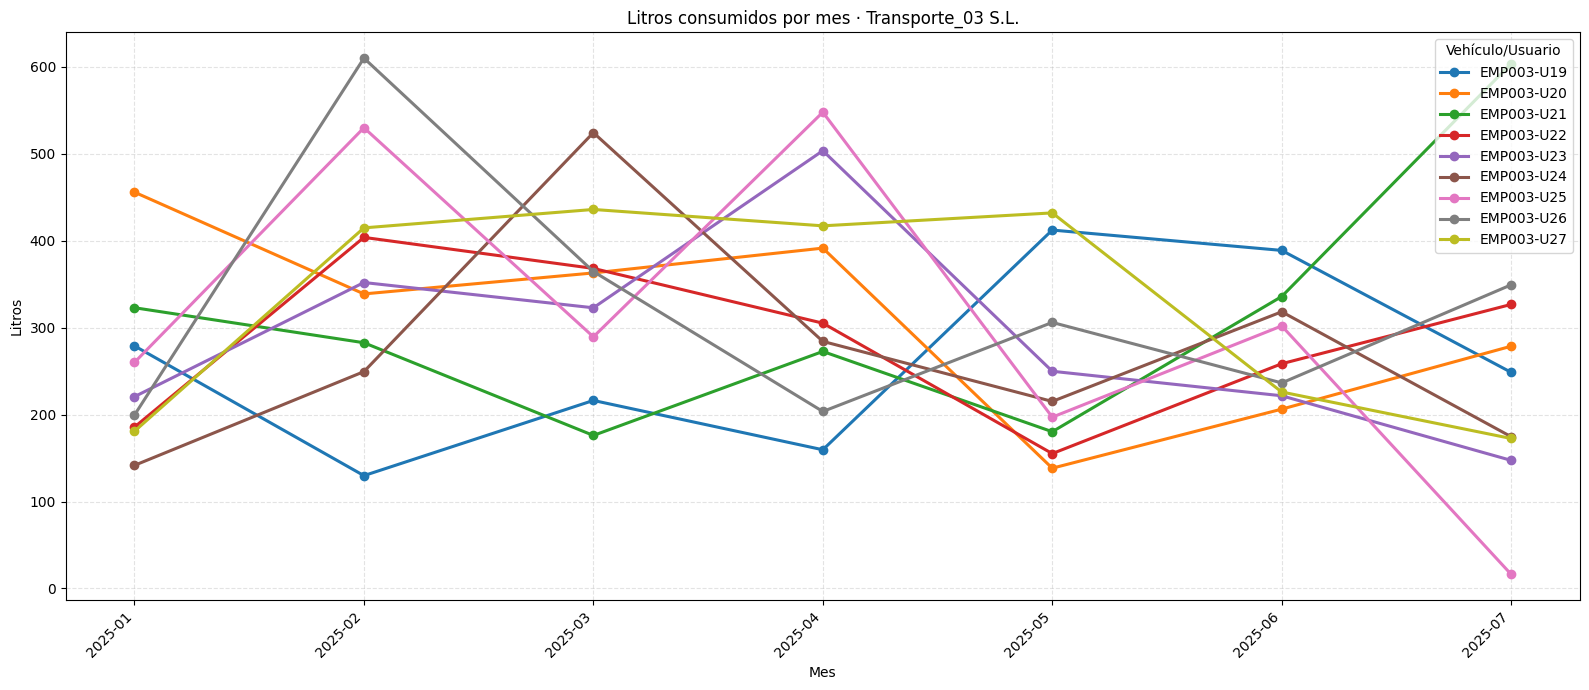

In [54]:
for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    plt.figure(figsize=(16,7))
    for u in users:
        tmp = (litros_emp_user_mes[(litros_emp_user_mes["empresa"]==e) & (litros_emp_user_mes["idUsuario"]==u)]
               .set_index("mes").reindex(MESES_ALL).fillna(0))
        plt.plot(MESES_ALL, tmp["litros"].values, marker="o", linewidth=2.2, label=str(u), color=cmap[u])
    plt.title(f"Litros consumidos por mes · {e}")
    plt.xlabel("Mes"); plt.ylabel("Litros")
    plt.xticks(rotation=45, ha="right"); plt.grid(True, linestyle="--", alpha=0.35); plt.legend(title="Vehículo/Usuario")
    plt.tight_layout(); plt.show()


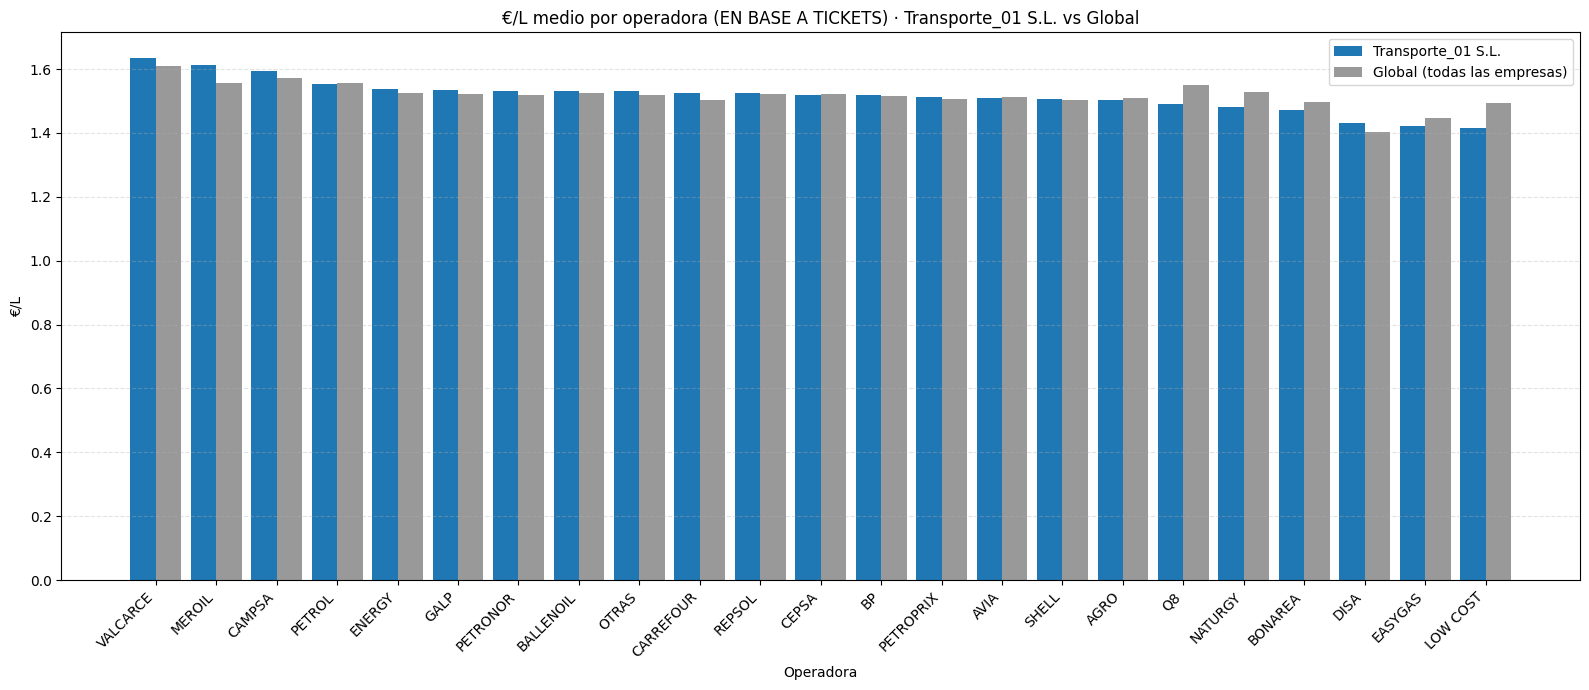

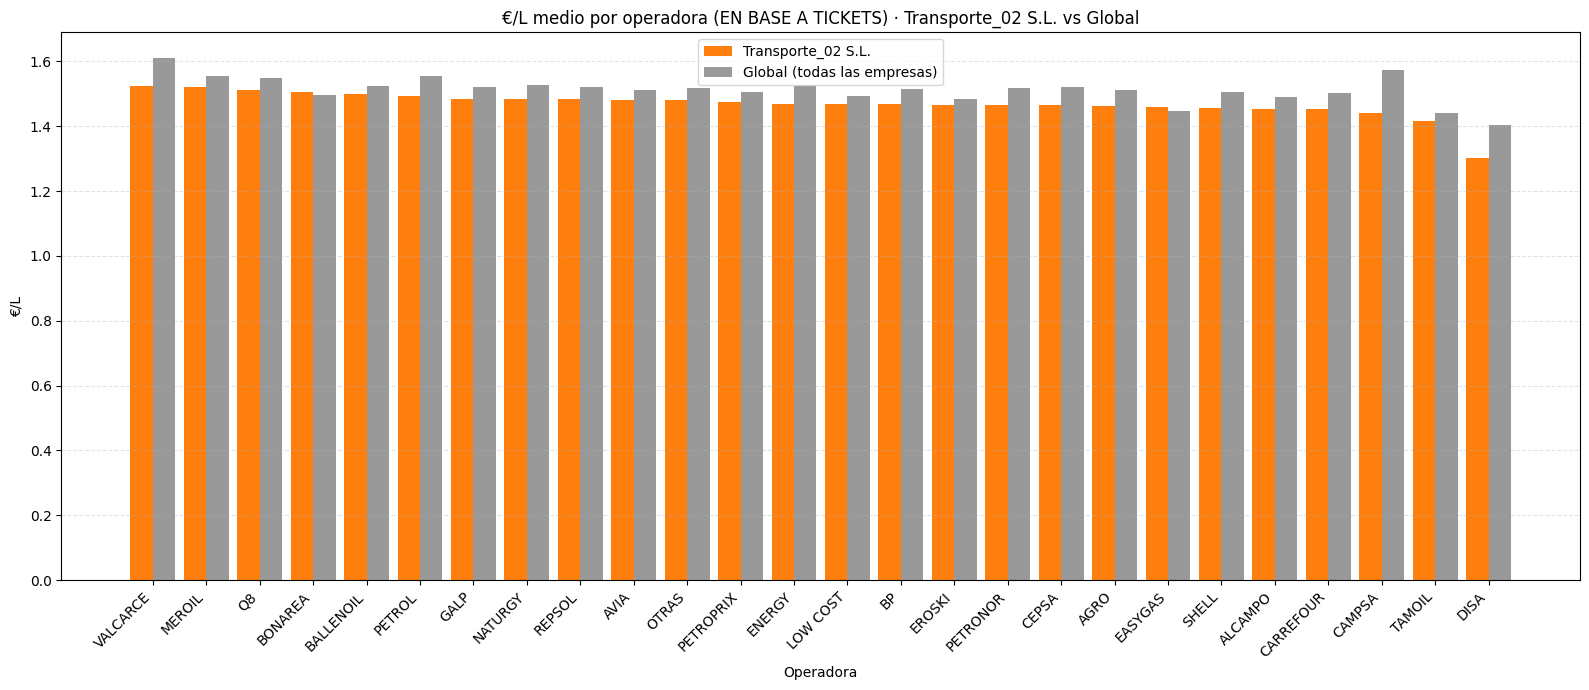

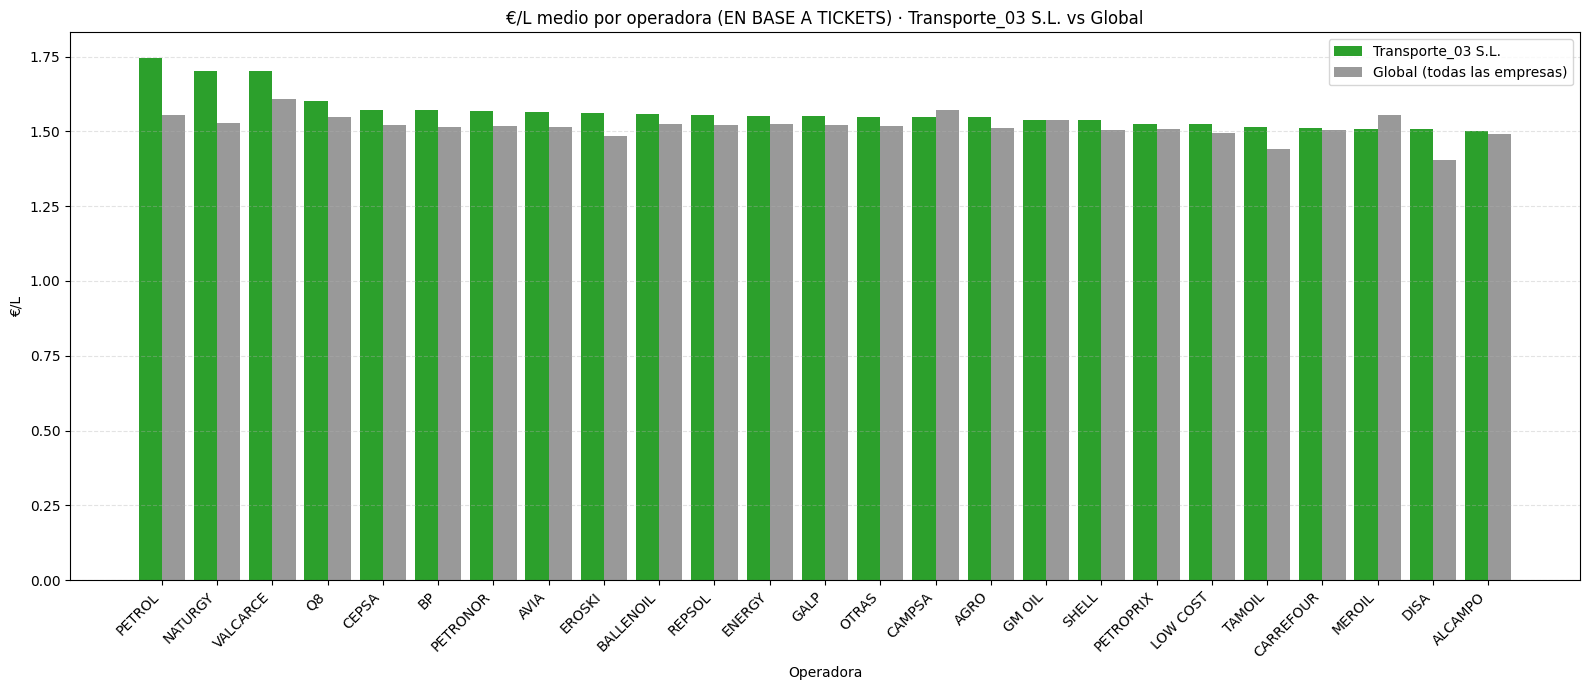

In [55]:
ticket_prices = (
    df[["idTicket","empresaNombre","estacion_marca"]]
    .merge(tk[["idTicket","eur_l_total_ticket"]], on="idTicket", how="left")
    .rename(columns={"empresaNombre":"empresa", "eur_l_total_ticket":"eur_l_ticket"})
    .dropna(subset=["estacion_marca","eur_l_ticket"])
)

pm_global_ticket = (
    ticket_prices.groupby("estacion_marca")["eur_l_ticket"]
    .mean()
    .rename("eur_l_global_ticket")
    .reset_index()
)

pm_empresa_ticket = (
    ticket_prices.groupby(["empresa","estacion_marca"])["eur_l_ticket"]
    .mean()
    .rename("eur_l_empresa_ticket")
    .reset_index()
)

NEUTRAL = "#999999"
tablas_comp_por_empresa = {}

for e in sorted(pm_empresa_ticket["empresa"].unique()):
    cmp_e = (pm_empresa_ticket[pm_empresa_ticket["empresa"]==e]
                .merge(pm_global_ticket, on="estacion_marca", how="left"))
    cmp_e = cmp_e.sort_values("eur_l_empresa_ticket", ascending=False)
    tablas_comp_por_empresa[e] = cmp_e.assign(delta=cmp_e["eur_l_empresa_ticket"] - cmp_e["eur_l_global_ticket"])
    x = np.arange(len(cmp_e))
    width = 0.42
    plt.figure(figsize=(16,7))
    plt.bar(x - width/2, cmp_e["eur_l_empresa_ticket"], width=width,
            label=f"{e}", color=EMP_COLOR.get(e,"C0"))
    plt.bar(x + width/2, cmp_e["eur_l_global_ticket"], width=width,
            label="Global (todas las empresas)", color=NEUTRAL)
    plt.title(f"€/L medio por operadora (EN BASE A TICKETS) · {e} vs Global")
    plt.xlabel("Operadora"); plt.ylabel("€/L")
    plt.xticks(x, cmp_e["estacion_marca"].astype(str), rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

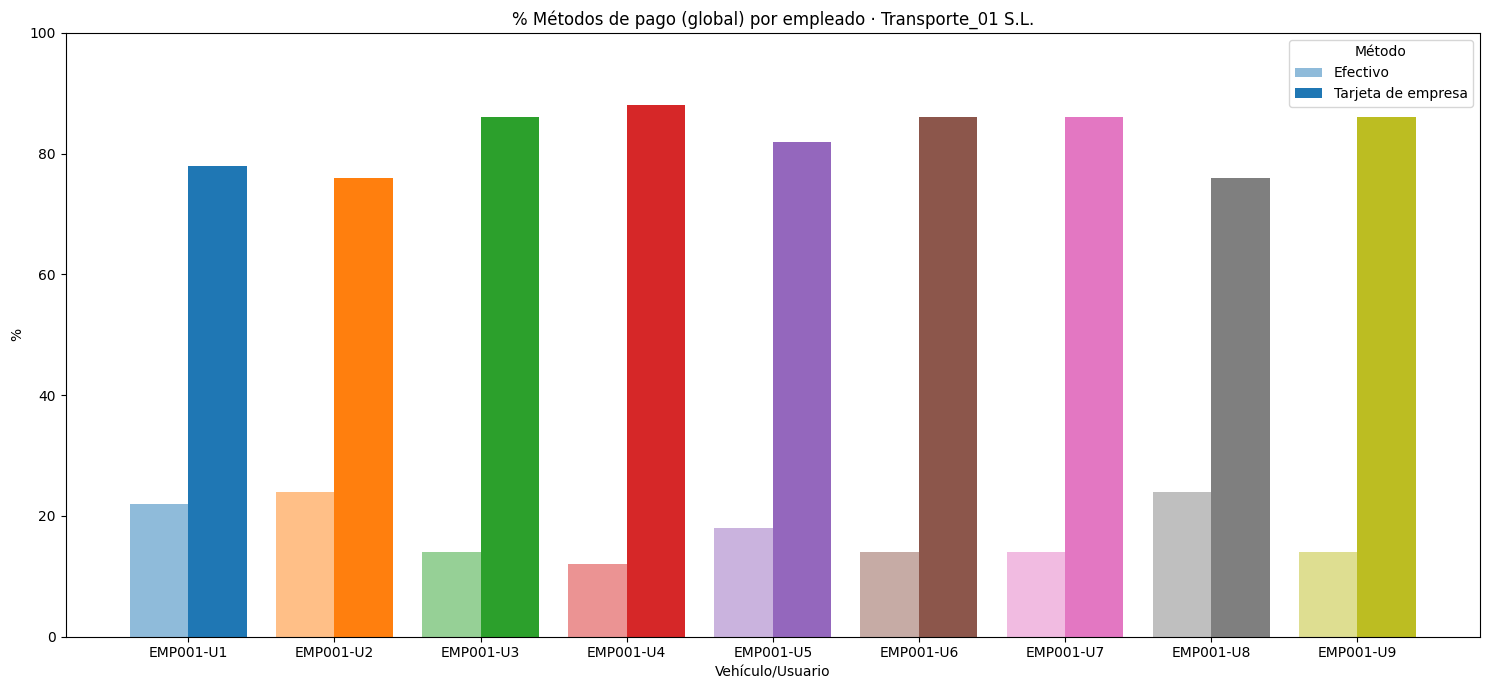

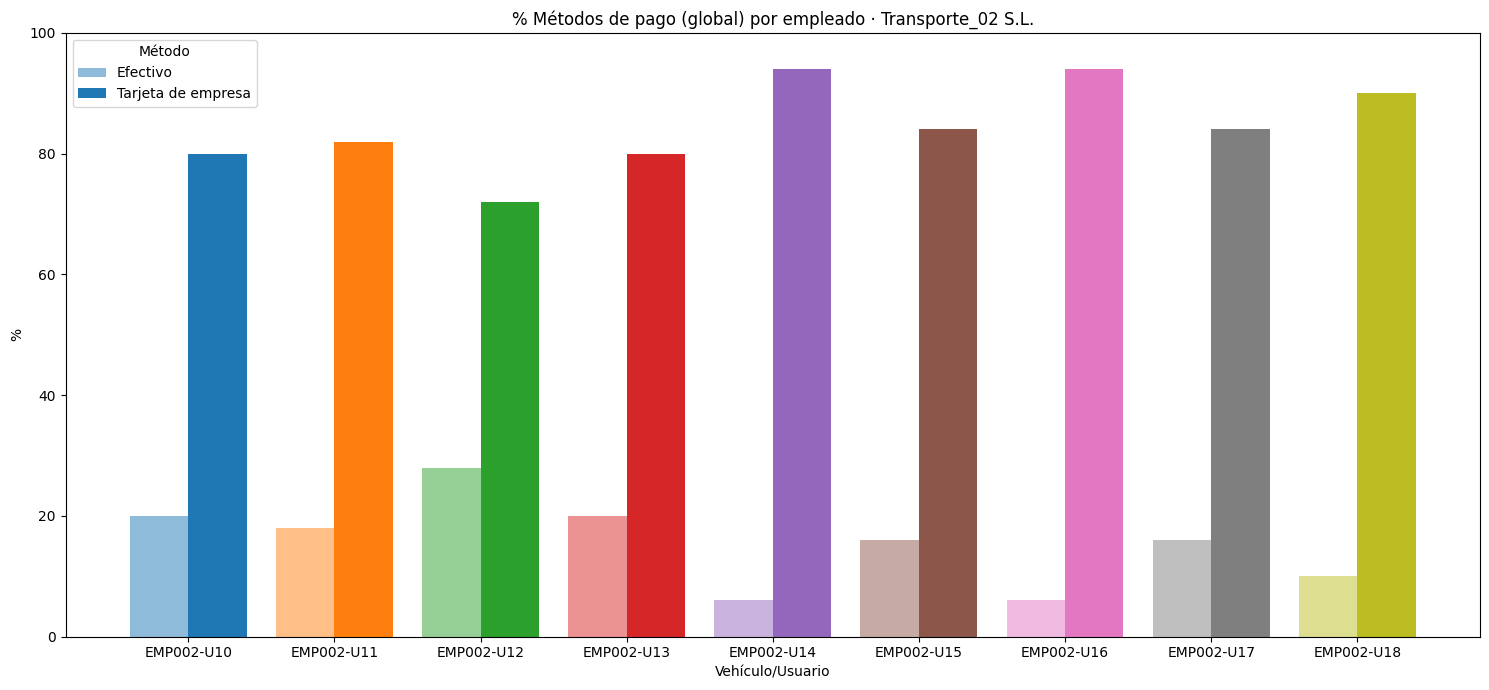

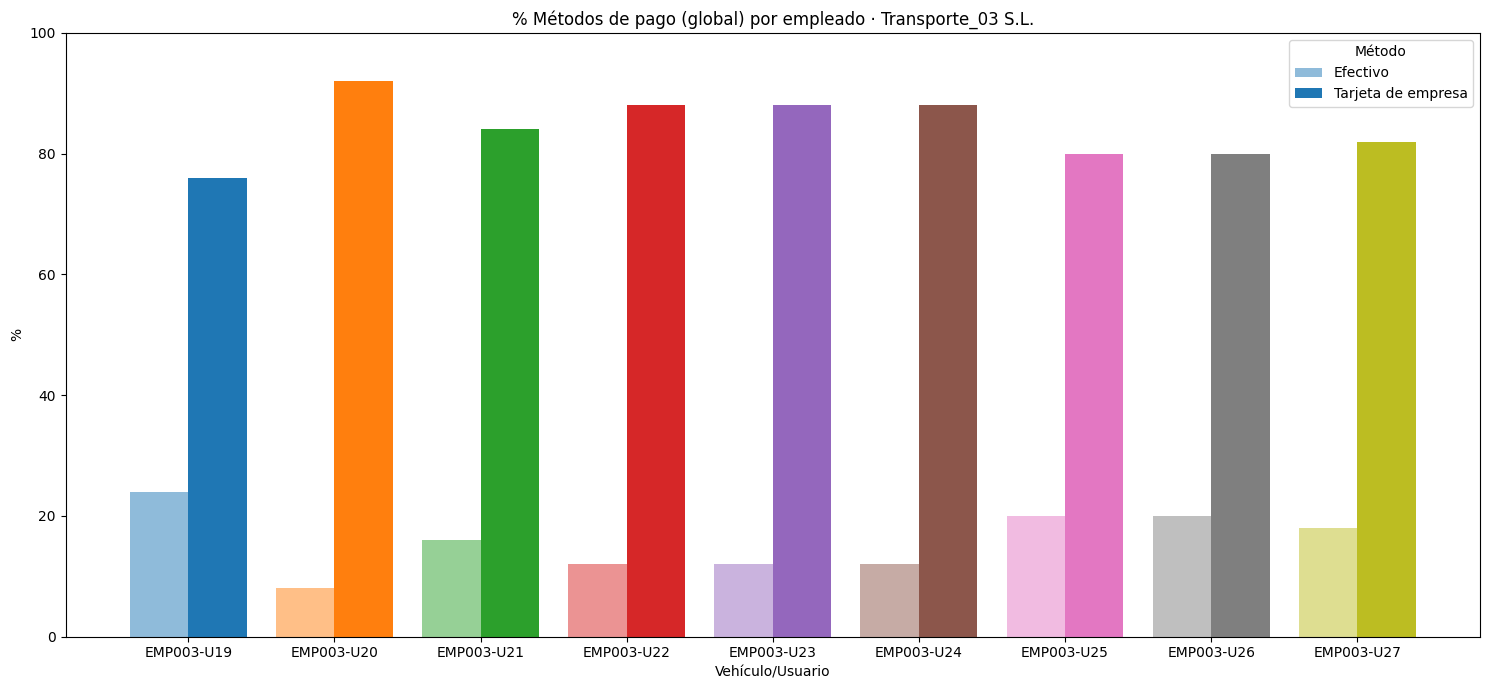

In [56]:
def lighten_color(c, amount=0.5):
    r, g, b = mcolors.to_rgb(c)
    return (1 - (1 - r)*(1 - amount),
            1 - (1 - g)*(1 - amount),
            1 - (1 - b)*(1 - amount))

for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    pivot = (metodos_emp_user[metodos_emp_user["empresa"]==e]
             .assign(total=lambda x: x.groupby("idUsuario")["tickets"].transform("sum"))
             .assign(pct=lambda x: 100*x["tickets"]/x["total"])
             .pivot(index="idUsuario", columns="metodoPago", values="pct")
             .reindex(users)
             .fillna(0))

    plt.figure(figsize=(15,7))
    x = np.arange(len(pivot.index))
    width = 0.8 / max(1, len(pivot.columns))
    offset = - (len(pivot.columns) - 1) * width / 2

    for i, m in enumerate(pivot.columns):
        if str(m).lower().strip() in {"efectivo"}:
            bar_colors = [lighten_color(cmap[u], amount=0.5) for u in pivot.index]
        else:
            bar_colors = [cmap[u] for u in pivot.index]

        plt.bar(x + offset + i*width, pivot[m].values, width=width,
                label=str(m), color=bar_colors)

    plt.title(f"% Métodos de pago (global) por empleado · {e}")
    plt.xlabel("Vehículo/Usuario"); plt.ylabel("%"); plt.ylim(0,100)
    plt.xticks(x, pivot.index.astype(str), rotation=0)
    plt.legend(title="Método")
    plt.tight_layout(); plt.show()


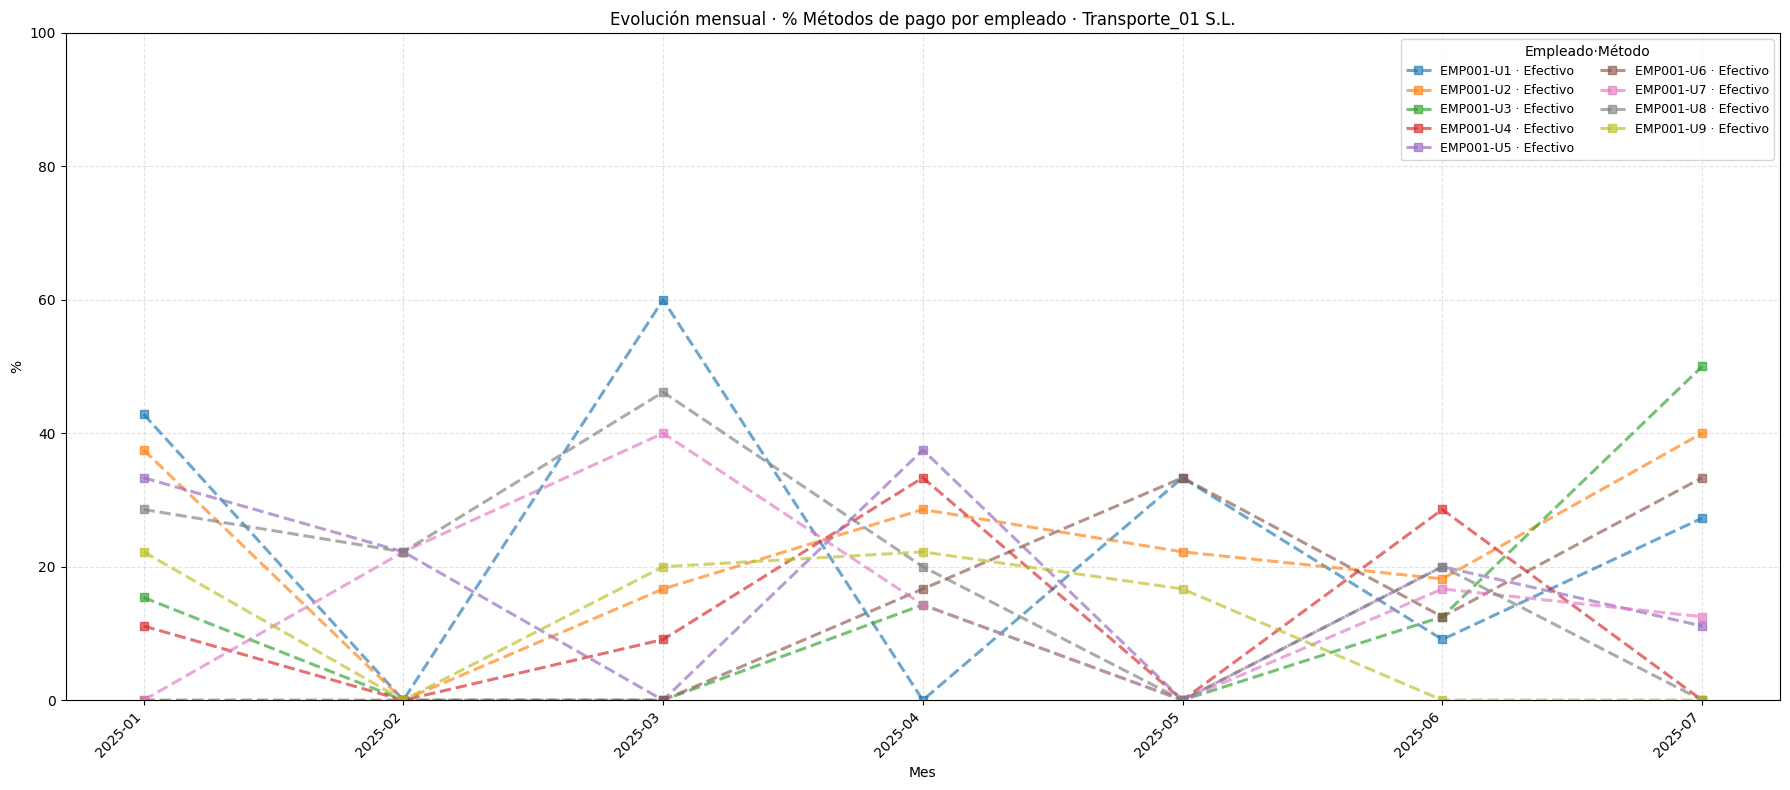

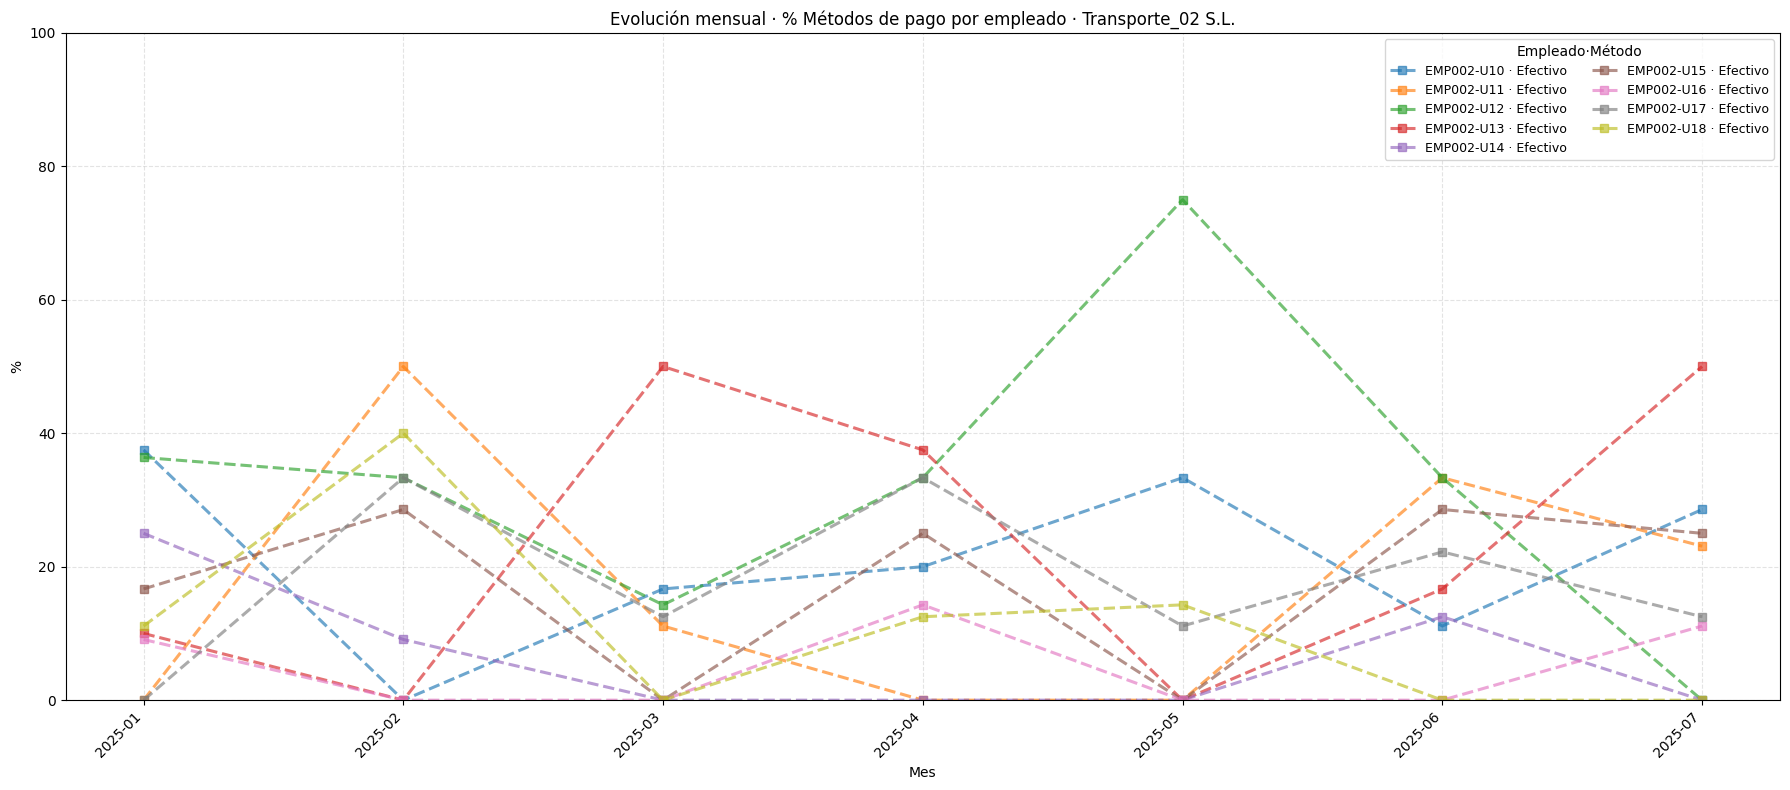

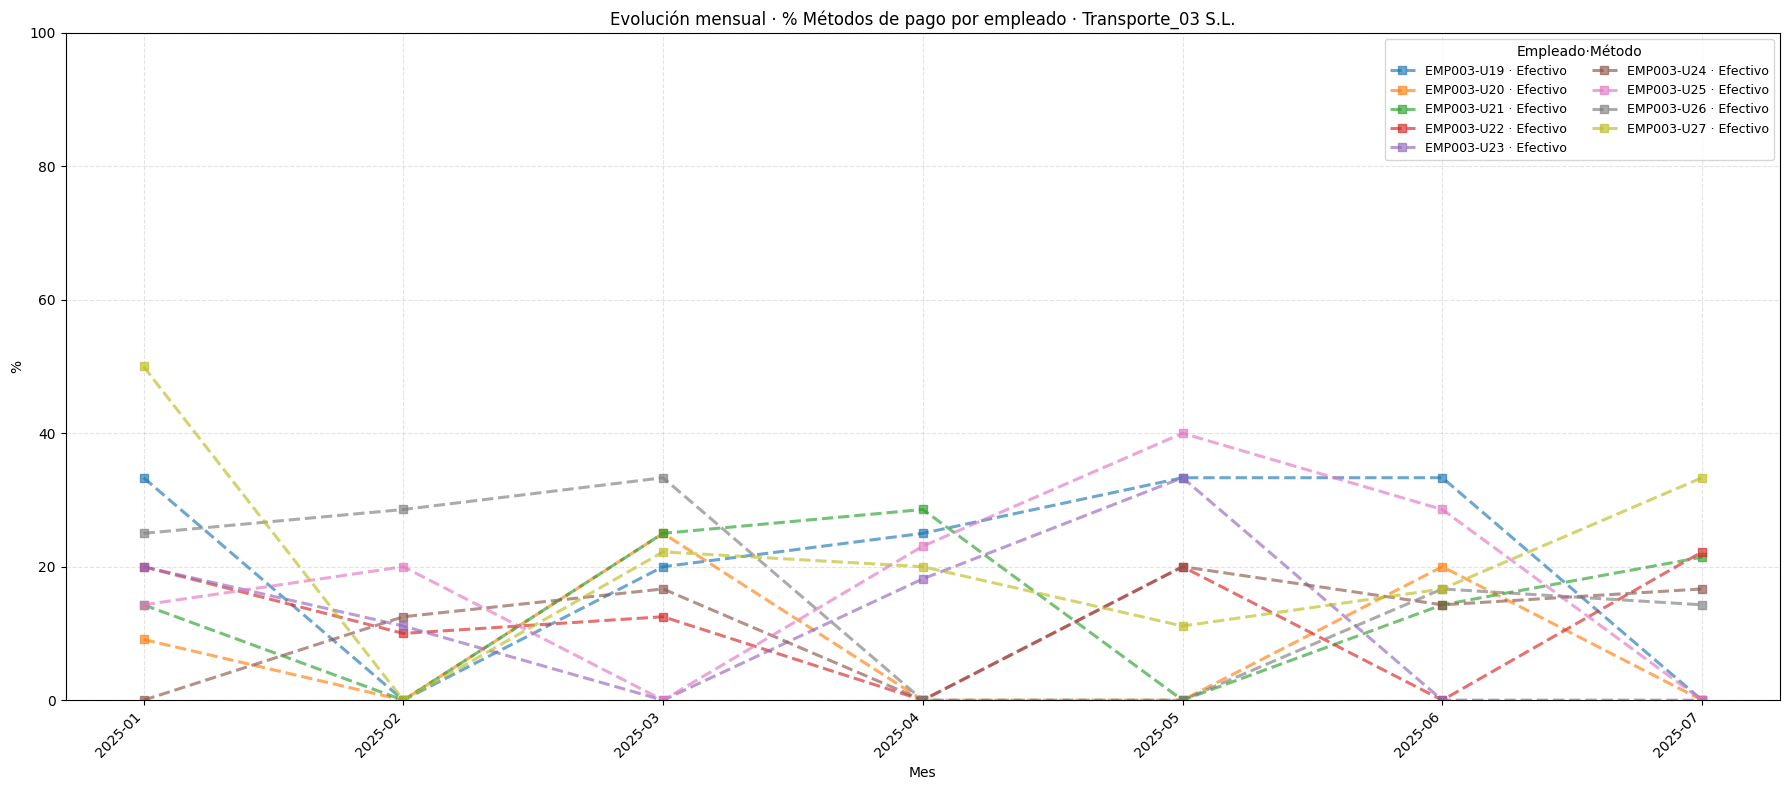

In [57]:
MESES_M = sorted(metodos_emp_user_mes["mes"].unique().tolist())
ORDER = ["Tarjeta","Efectivo"]

for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    plt.figure(figsize=(18,8))
    for u in users:
        pivot = (metodos_emp_user_mes[(metodos_emp_user_mes["empresa"]==e) & (metodos_emp_user_mes["idUsuario"]==u)]
                 .pivot(index="mes", columns="metodoPago", values="pct")
                 .reindex(MESES_M).fillna(0))
        if "Tarjeta" in pivot.columns:
            plt.plot(MESES_M, pivot["Tarjeta"].values,
                     label=f"{u} · Tarjeta", color=cmap[u], linestyle="-", marker="o", linewidth=2.2, alpha=0.95)
        if "Efectivo" in pivot.columns:
            plt.plot(MESES_M, pivot["Efectivo"].values,
                     label=f"{u} · Efectivo", color=cmap[u], linestyle="--", marker="s", linewidth=2.2, alpha=0.65)
    plt.title(f"Evolución mensual · % Métodos de pago por empleado · {e}")
    plt.xlabel("Mes"); plt.ylabel("%"); plt.ylim(0,100)
    plt.xticks(rotation=45, ha="right"); plt.grid(True, linestyle="--", alpha=0.35); plt.legend(ncol=2, fontsize=9, title="Empleado·Método")
    plt.tight_layout(); plt.show()


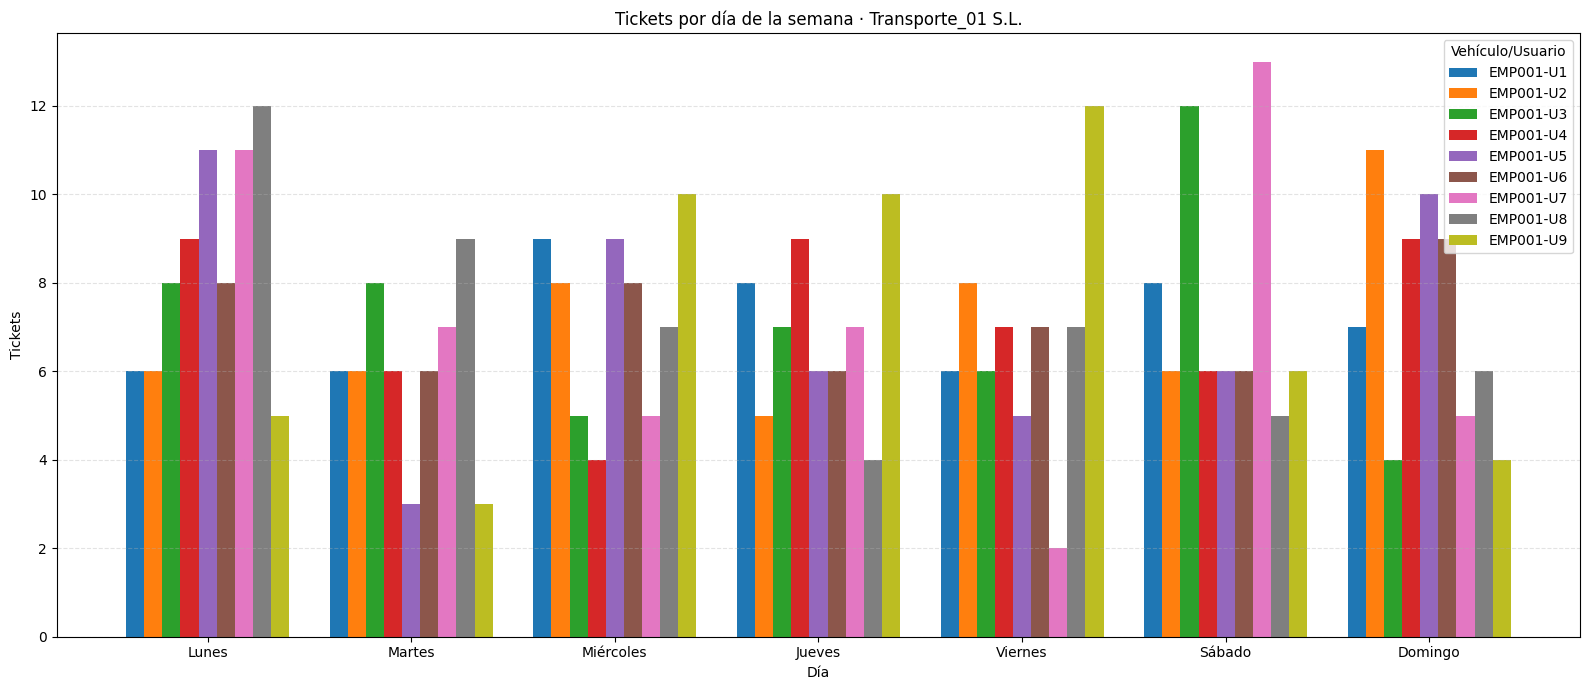

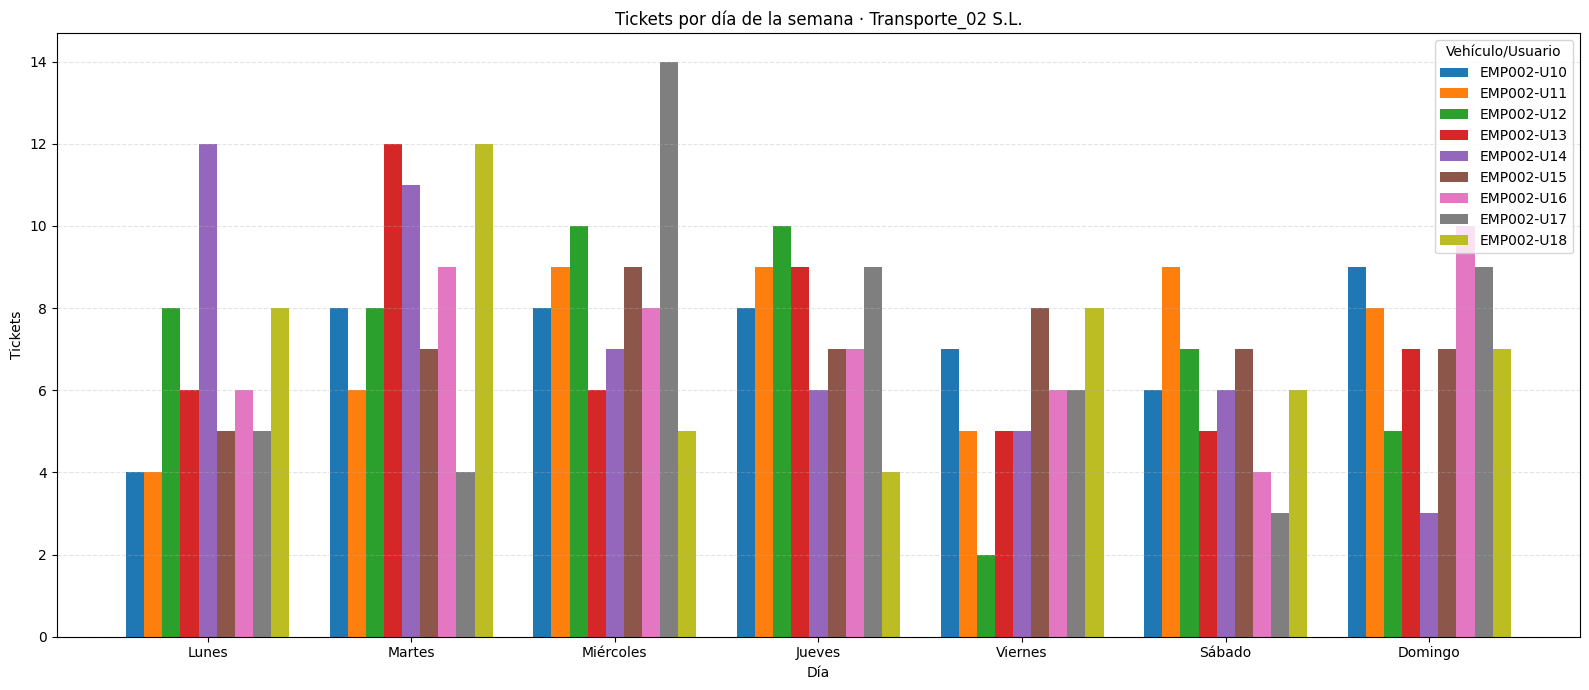

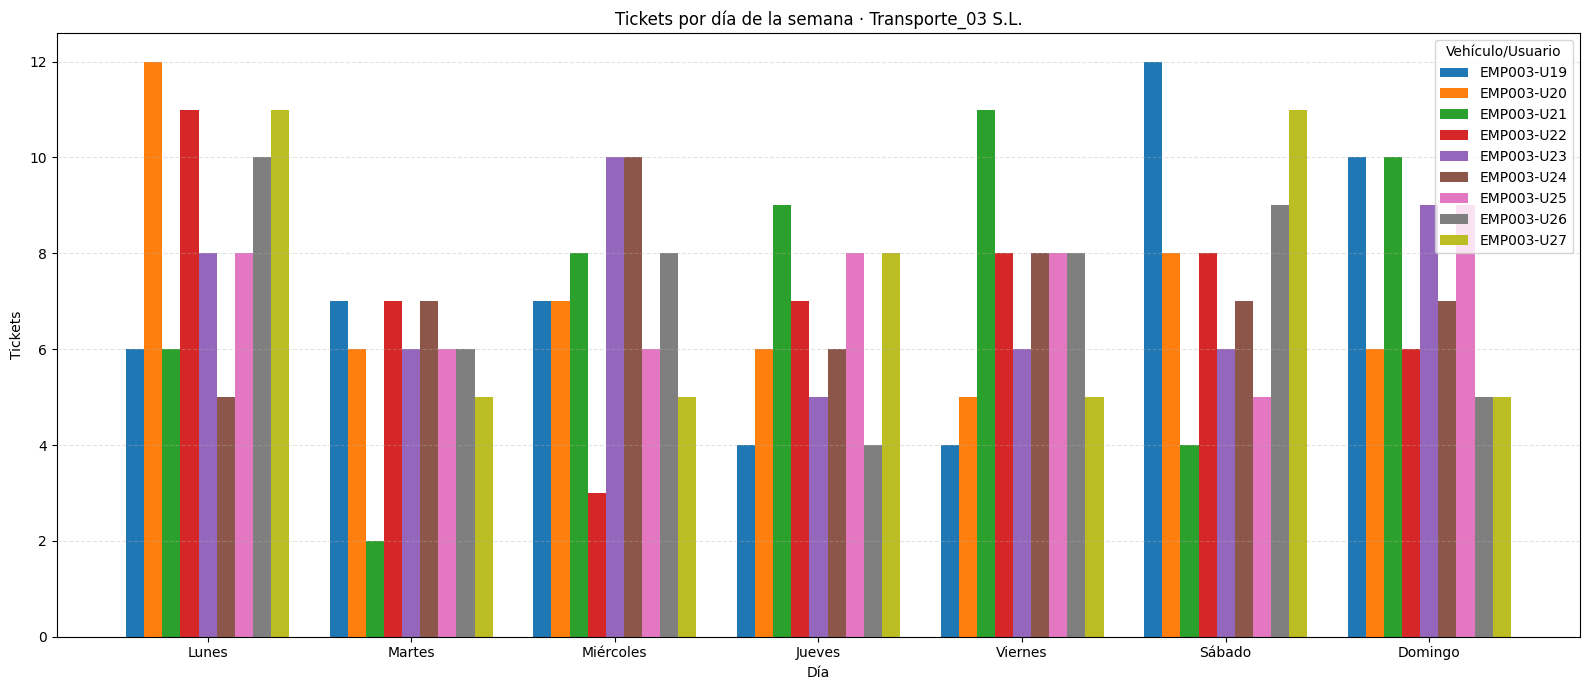

In [58]:
for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    pivot = (tickets_dia_emp_user[tickets_dia_emp_user["empresa"]==e]
             .pivot(index="dia_semana", columns="idUsuario", values="tickets")
             .reindex(orden_sem).fillna(0))
    x = np.arange(len(pivot.index))
    w = 0.8 / max(1, len(users))
    plt.figure(figsize=(16,7))
    for i,u in enumerate(users):
        vals = pivot[u].values if u in pivot.columns else np.zeros(len(x))
        plt.bar(x + i*w - 0.4 + w/2, vals, width=w, label=str(u), color=cmap[u])
    plt.title(f"Tickets por día de la semana · {e}")
    plt.xlabel("Día"); plt.ylabel("Tickets")
    plt.xticks(x, pivot.index.astype(str))
    plt.legend(title="Vehículo/Usuario")
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.tight_layout(); plt.show()


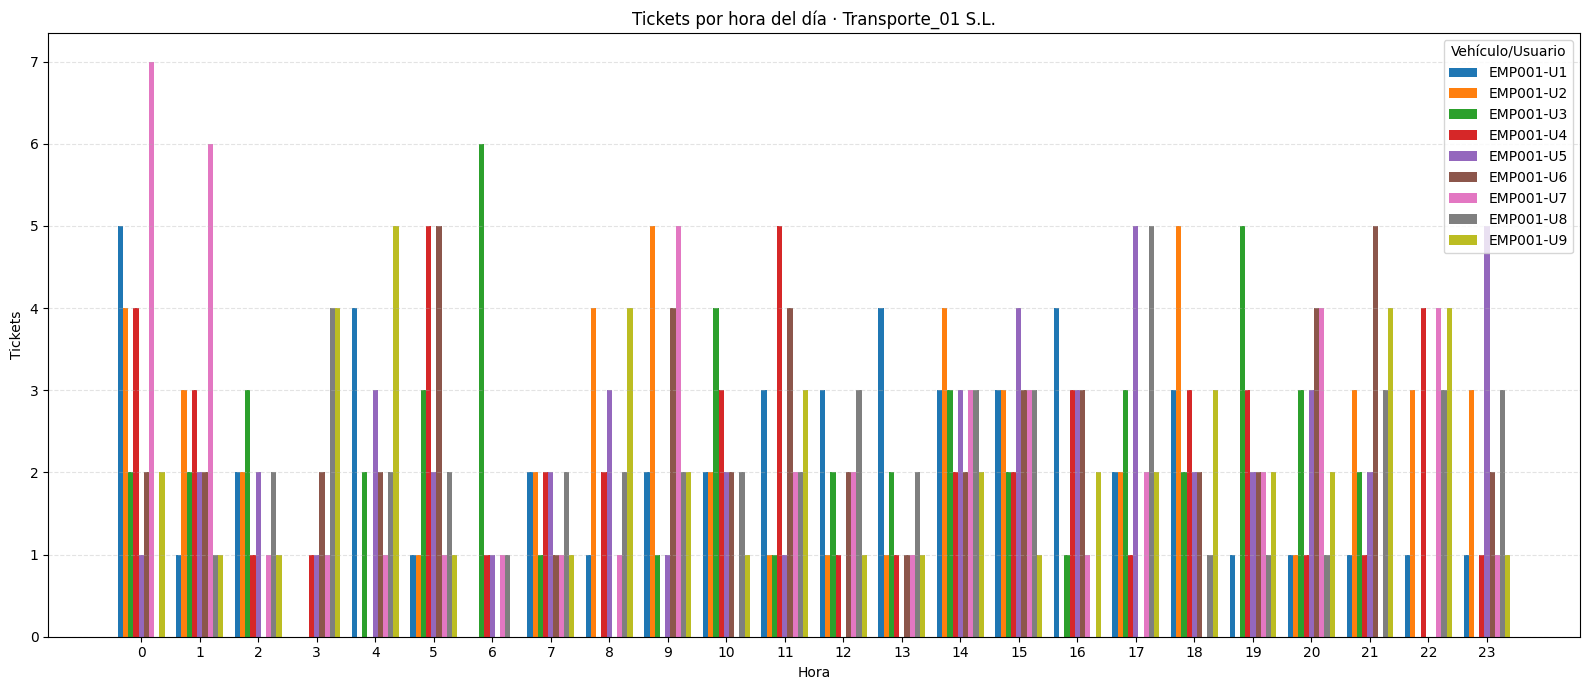

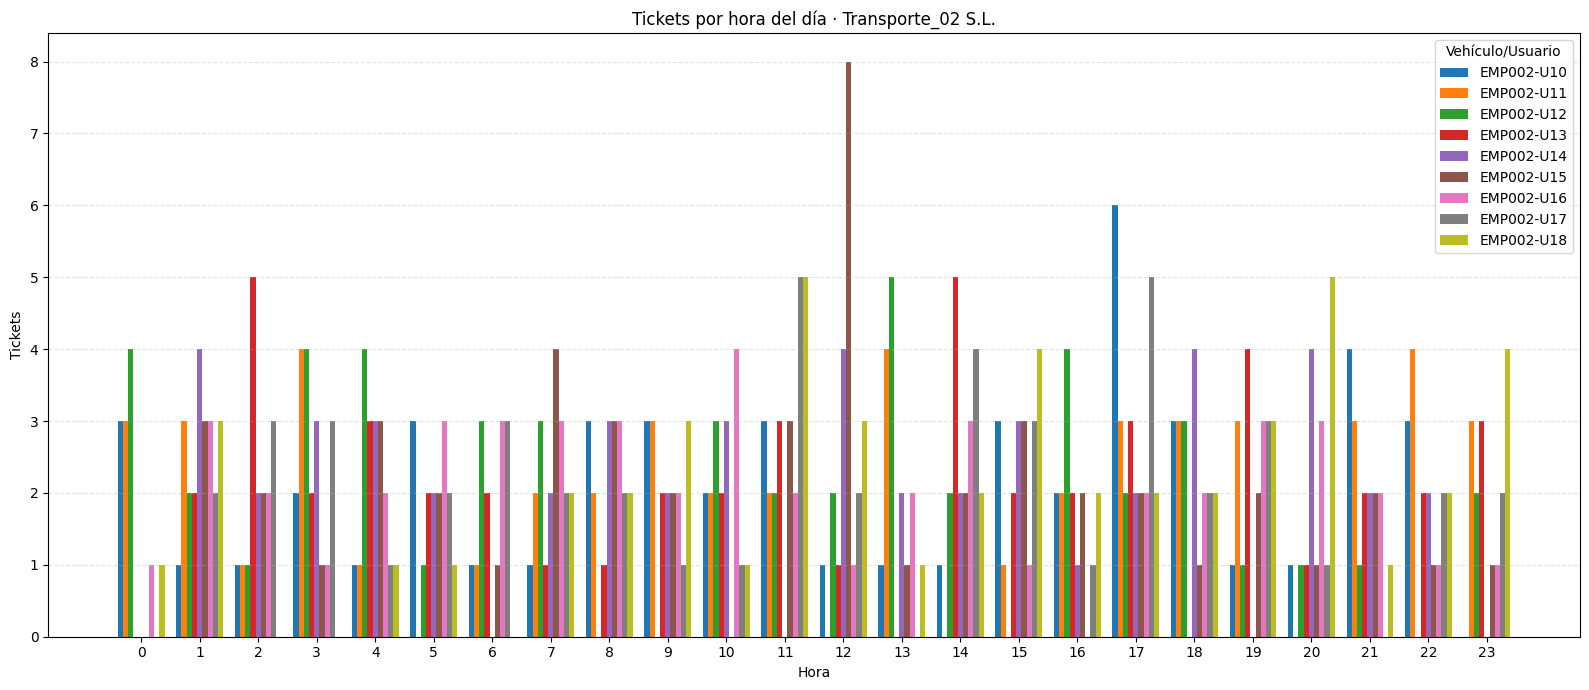

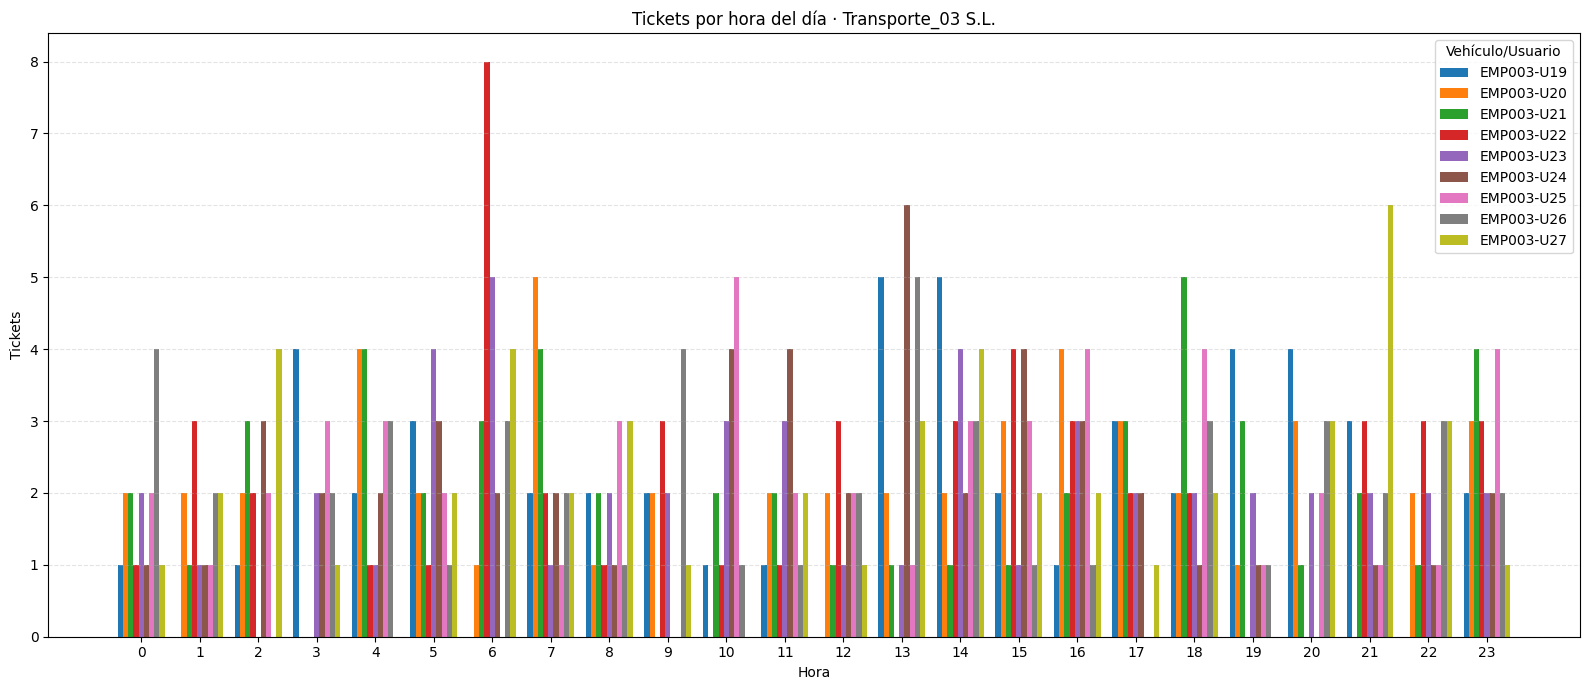

In [59]:
for e in sorted(emp_users["empresa"].unique()):
    users, cmap = user_colors_for_company(e)
    pivot = (tickets_hora_emp_user[tickets_hora_emp_user["empresa"]==e]
             .pivot(index="hora", columns="idUsuario", values="tickets")
             .reindex(range(0,24)).fillna(0))
    x = np.arange(len(pivot.index))
    w = 0.8 / max(1, len(users))
    plt.figure(figsize=(16,7))
    for i,u in enumerate(users):
        vals = pivot[u].values if u in pivot.columns else np.zeros(len(x))
        plt.bar(x + i*w - 0.4 + w/2, vals, width=w, label=str(u), color=cmap[u])
    plt.title(f"Tickets por hora del día · {e}")
    plt.xlabel("Hora"); plt.ylabel("Tickets")
    plt.xticks(x, pivot.index)
    plt.legend(title="Vehículo/Usuario")
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.tight_layout(); plt.show()


In [60]:
tabla_gasto_total_emp_user = (df.groupby(["empresaNombre","idUsuario"])["total"]
                              .sum().reset_index()
                              .rename(columns={"empresaNombre":"empresa","total":"gasto_total_usuario"}))

tabla_litros_total_emp_user = (df_lines.groupby(["empresaTransporte","idUsuario"])["litros"]
                               .sum().reset_index()
                               .rename(columns={"empresaTransporte":"empresa","litros":"litros_total_usuario"}))

tabla_precio_emp_user = precio_emp_user.rename(columns={"eur_l":"precio_medio_eur_l"})

tabla_metodos_pct_emp_user = (metodos_emp_user
                              .assign(total=lambda x: x.groupby(["empresa","idUsuario"])["tickets"].transform("sum"))
                              .assign(pct=lambda x: 100*x["tickets"]/x["total"])
                              .pivot_table(index=["empresa","idUsuario"], columns="metodoPago", values="pct", fill_value=0)
                              .reset_index())

tabla_resumen_emp_user = (tabla_gasto_total_emp_user
                          .merge(tabla_litros_total_emp_user, on=["empresa","idUsuario"], how="left")
                          .merge(tabla_precio_emp_user, on=["empresa","idUsuario"], how="left")
                          .merge(tabla_metodos_pct_emp_user, on=["empresa","idUsuario"], how="left")
                         ).sort_values(["empresa","gasto_total_usuario"], ascending=[True,False])

tabla_resumen_emp_user.head()


,empresa,idUsuario,gasto_total_usuario,litros_total_usuario,precio_medio_eur_l,Efectivo,Tarjeta de empresa
6,Transporte_01 S.L.,EMP001-U7,3582.94,2341.42,1.530242,14.0,86.0
8,Transporte_01 S.L.,EMP001-U9,3478.60,2070.65,1.679956,14.0,86.0
5,Transporte_01 S.L.,EMP001-U6,3457.00,2427.75,1.423952,14.0,86.0
2,Transporte_01 S.L.,EMP001-U3,3423.80,2024.38,1.691283,14.0,86.0
1,Transporte_01 S.L.,EMP001-U2,3333.87,2213.96,1.505840,24.0,76.0


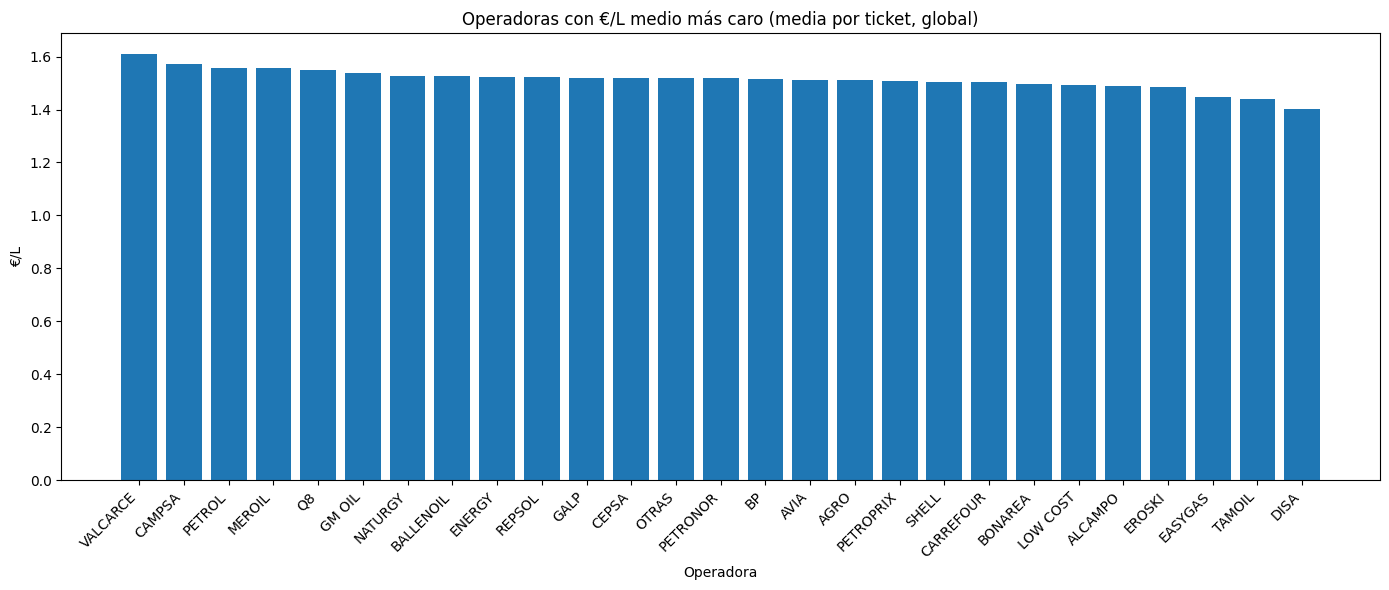

In [61]:
if "tk" not in locals():
    ticket_litros = df_lines.groupby("idTicket")["litros"].sum().rename("litros_ticket")
    ticket_totales = df.groupby("idTicket")[["baseImponible","total"]].sum()
    tk = pd.concat([ticket_litros, ticket_totales], axis=1).reset_index()
    tk["eur_l_total_ticket"] = np.where(tk["litros_ticket"]>0, tk["total"]/tk["litros_ticket"], np.nan)

eur_l_operadora_ticket = (
    df[["idTicket","estacion_marca"]]
    .merge(tk[["idTicket","eur_l_total_ticket"]], on="idTicket", how="left")
    .dropna(subset=["estacion_marca","eur_l_total_ticket"])
    .groupby("estacion_marca")["eur_l_total_ticket"].mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(14,6))
plt.bar(eur_l_operadora_ticket.index.astype(str), eur_l_operadora_ticket.values)
plt.title("Operadoras con €/L medio más caro (media por ticket, global)")
plt.xlabel("Operadora"); plt.ylabel("€/L")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()